In [1]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from matplotlib import patches
import tensorflow as tf
from tensorflow.keras.models import load_model
from utils import *
from SISE import SISE as sise
import os
import xml.etree.ElementTree as ET

In [2]:
classese = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13,
 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

label_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/Annotations'
test_data_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/test'
img_name_list = []

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):
        img_name_list.append((class_name, annotation))


aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor


In [3]:
model = load_model('model/resnet50_voc2007')

In [5]:
test_data = '006173.jpg'
# AC-SISE
ac_sise = sise(model, 'resnet50', f'{test_data_path}/cow/{test_data}', classese['cow'])
ac_sise.feature_extractor()
ac_sise.feature_filtering()
ac_sise.filtering_zero_feature_maps()
ac_sise.postprocess()
ac_sise.new_attribution_masks_compress1(1)
ac_sise.generate_layer_visualization_map()
ac_sise.layers_fusion()

64 -> 29, 35개 감소 (감소율: -54.6875%)
256 -> 131, 125개 감소 (감소율: -48.828125%)
512 -> 266, 246개 감소 (감소율: -48.046875%)
1024 -> 586, 438개 감소 (감소율: -42.7734375%)
2048 -> 216, 1832개 감소 (감소율: -89.453125%)

Total
3904 -> 1228, 2676개 감소 (감소율: -68.54508196721312%)



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [200]:
tree = ET.parse(f'{label_path}/{test_data.replace(".jpg", ".xml")}')
root = tree.getroot()
anno_bbox = get_label(root)
bbox = generate_bbox(normalization(ac_sise.result), 0.2)

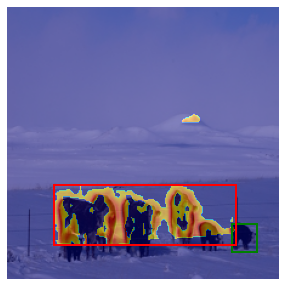

In [201]:
plt.figure(figsize=(5,5))
plt.imshow(ac_sise.img)
plt.imshow(normalization(ac_sise.result), cmap='jet', alpha=0.5)
# plt.colorbar()
ax = plt.gca()
rect1 = patches.Rectangle((anno_bbox['xmin'], anno_bbox['ymin']), anno_bbox['w'], anno_bbox['h'], linewidth=2, edgecolor='g', facecolor='none')
rect2 = patches.Rectangle((bbox[1], bbox[0]), (bbox[3]-bbox[1]), (bbox[2]-bbox[0]), linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.axis('off')
plt.show()

In [5]:
classese = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13,
 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

label_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/Annotations'
test_data_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/test'

In [6]:
ebpg_result = list()
iou_result = list()
elapsed_time_list = list()
total_reduction_rate_list = list()

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):    
        tree = ET.parse(f'{label_path}/{annotation.replace(".jpg", ".xml")}')
        root = tree.getroot()
        anno_bbox = get_label(root)

        ac_sise = SISE(model, 'resnet50', f'{test_data_path}/{class_name}/{annotation}', class_index)
        ac_sise.feature_extractor()
        ac_sise.feature_filtering()
        ac_sise.filtering_zero_feature_maps()
        ac_sise.postprocess()
        ac_sise.attribution_masks_compress()
        start = time.time()
        ac_sise.generate_layer_visualization_map()
        ac_sise.layers_fusion()
        end = time.time()
        
        ebpg_result.append(energy_point_game((round(anno_bbox['xmin']), round(anno_bbox['ymin']), round(anno_bbox['xmax']), round(anno_bbox['ymax'])), ac_sise.result))
        bbox = generate_bbox(normalization(ac_sise.result), 0.2)
        iou_result.append(IoU(bbox, (round(anno_bbox['ymin']), round(anno_bbox['xmin']), round(anno_bbox['ymax']), round(anno_bbox['xmax']))))
        elapsed_time_list.append(end-start)
        total_reduction_rate_list.append(ac_sise.total_reduction_rate)

    df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
    df.to_excel(excel_writer=f'./resnet50_result/AC_SISE_0207/AC_SISE_resnet50_{class_name}_0207_iou0.9.xlsx')

aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor


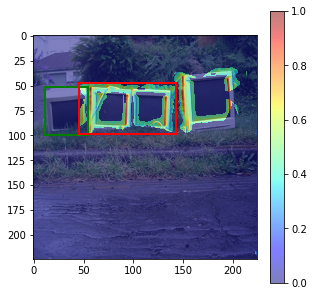

In [16]:
plt.figure(figsize=(5,5))
plt.imshow(ac_sise.img)
plt.imshow(normalization(ac_sise.result), cmap='jet', alpha=0.5)
plt.colorbar()
ax = plt.gca()
rect1 = patches.Rectangle((anno_bbox['xmin'], anno_bbox['ymin']), anno_bbox['w'], anno_bbox['h'], linewidth=2, edgecolor='g', facecolor='none')
rect2 = patches.Rectangle((bbox[1], bbox[0]), (bbox[3]-bbox[1]), (bbox[2]-bbox[0]), linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

In [7]:
print('Mean EBPG:', sum(ebpg_result)/len(ebpg_result))
print('Mean IoU:', sum(iou_result)/len(iou_result))
print('Mean elapsed time:', sum(elapsed_time_list)/len(elapsed_time_list))
print('Mean total reduction rate:', sum(total_reduction_rate_list)/len(total_reduction_rate_list))

Mean EBPG: 0.49962150174687525
Mean IoU: 0.10622948422708207
Mean elapsed time: 3.2137840706289333
Mean total reduction rate: -72.01135391415929


In [8]:
df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})

In [9]:
df.to_excel(excel_writer='AC_SISE_resnet50_0207_iou0.9.xlsx')

In [6]:
classese = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13,
 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

label_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/Annotations'
test_data_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/test'
img_name_list = []

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):
        img_name_list.append((class_name, annotation))


aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor


('bus', '009122.jpg')


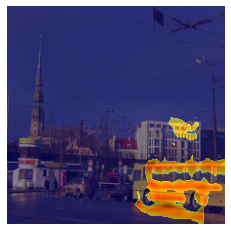

In [173]:
idx = 1265
print(img_name_list[idx])
# test = SISE(model, 'resnet50', f'D:/dataset/PASCAL_VOC_2007/VOC2007/test/{img_name_list[idx][0]}/{img_name_list[idx][1]}', classese[img_name_list[idx][0]])
# test.feature_extractor()
# test.feature_filtering()
# test.postprocess()
# test.generate_layer_visualization_map()
# test.layers_fusion()

# plt.imshow(test.img)
# plt.imshow(test.result, cmap='jet', alpha=0.5)
# # plt.colorbar()
# plt.axis('off')
# plt.show()

# sise_result = test.result

test = SISE(model, 'resnet50', f'D:/dataset/PASCAL_VOC_2007/VOC2007/test/{img_name_list[idx][0]}/{img_name_list[idx][1]}', classese[img_name_list[idx][0]])
test.feature_extractor()
test.feature_filtering()
test.filtering_zero_feature_maps()
test.postprocess()
test.attribution_masks_compress()
test.generate_layer_visualization_map()
test.layers_fusion()

plt.imshow(test.img)
plt.imshow(test.result, cmap='jet', alpha=0.5)
# plt.colorbar()
plt.axis('off')
plt.show()

# ac_sise_result = test.result

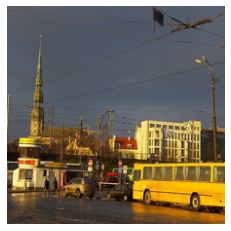

In [151]:
plt.imshow(test.img)
plt.axis('off')
plt.show()

In [126]:
sise_result = test.result

In [132]:
ac_sise_result = test.result

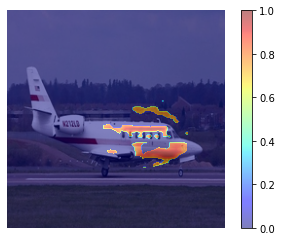

In [129]:
# SISE
plt.imshow(test.img)
plt.imshow(normalization(sise_result), cmap='jet', alpha=0.5)
plt.colorbar()
plt.axis('off')
plt.show()

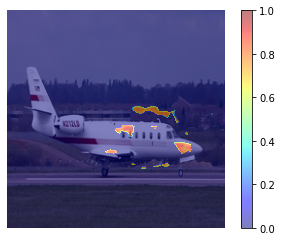

In [130]:
# AC-SISE
plt.imshow(test.img)
plt.imshow(normalization(ac_sise_result), cmap='jet', alpha=0.5)
plt.colorbar()
plt.axis('off')
plt.show()

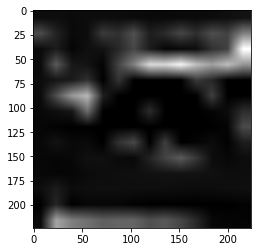

In [15]:
plt.imshow(test.postprocessed_feature_maps['conv3'][:,:,0], cmap='gray')

In [172]:
pp_fmap = test.postprocessed_feature_maps

In [174]:
test.group_bbox['conv3']

[[0],
 [1],
 [2, 486],
 [3],
 [4],
 [5, 152, 233, 419],
 [6, 125, 472],
 [7, 186],
 [8],
 [9, 110, 146, 173, 181, 241, 275, 303, 347, 409, 439],
 [10, 24],
 [11, 89, 366, 451],
 [12, 288, 483],
 [13],
 [14, 390],
 [15],
 [16, 150, 471],
 [17, 84, 99, 105, 250, 487],
 [18, 39, 93, 225, 304, 395, 450],
 [19, 28, 80, 207, 226, 254, 297, 349, 408, 493],
 [20],
 [21, 86, 103, 111, 236, 276, 352, 402, 485],
 [22, 79, 208],
 [23],
 [25, 270, 333, 356, 449],
 [26, 318],
 [27],
 [29, 187, 244],
 [30],
 [31],
 [32],
 [33, 339, 468],
 [34, 296],
 [35],
 [36],
 [37, 437],
 [38],
 [40],
 [41, 148],
 [42],
 [43],
 [44, 378, 407],
 [45, 139, 412, 469],
 [46, 324],
 [47],
 [48, 115],
 [49, 417],
 [50, 109],
 [51],
 [52, 78, 433],
 [53],
 [54, 168, 214],
 [55, 76, 351, 444, 447],
 [56],
 [57],
 [58, 100, 137, 200, 222, 248],
 [59],
 [60, 443],
 [61],
 [62, 72],
 [63],
 [64],
 [65, 394],
 [66],
 [67],
 [68],
 [69, 422],
 [70],
 [71],
 [73],
 [74],
 [75, 235],
 [77, 221],
 [81],
 [82],
 [83],
 [85],
 [87

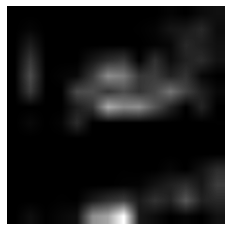

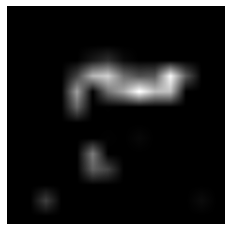

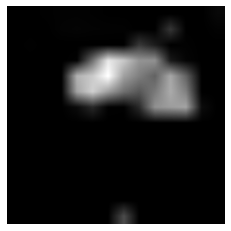

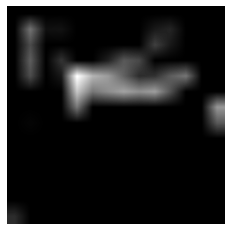

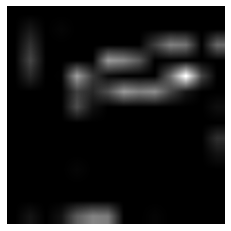

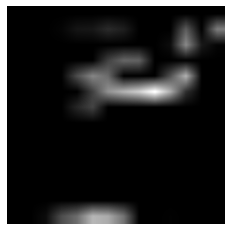

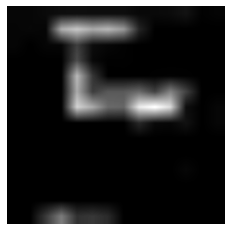

In [185]:
for i in test.group_bbox['conv3'][18]:
    plt.imshow(pp_fmap['conv3'][:,:,i], cmap='gray')
    plt.axis('off')
    plt.show()

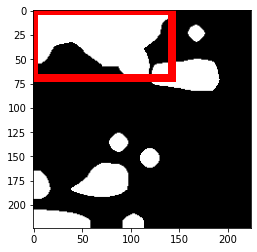

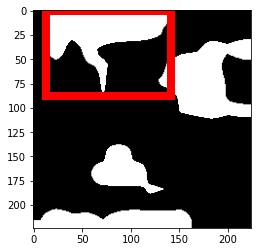

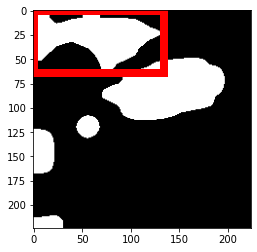

In [182]:
temp_bbox = []
temp_binary = []

for i, index in enumerate(test.group_bbox['conv3'][16]):
    ax = plt.gca()
    binary = otsu_binary(pp_fmap['conv3'][:,:,index])
    temp_binary.append(binary)
    labeled, nr_objects = label(binary > 0)
    props = regionprops(labeled)

    init = props[0].bbox_area
    bbox = tuple(props[0].bbox)
    for b in props:
        if init < b.bbox_area:
            init = b.bbox_area
            bbox = tuple(b.bbox)
        rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], linewidth=8, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.imshow(temp_binary[i], cmap='gray')
    plt.show()
    temp_bbox.append(bbox)

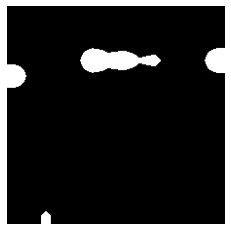

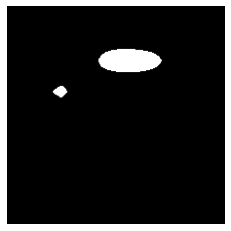

In [103]:
for bin_img in temp_binary:
    plt.imshow(bin_img, cmap='gray')
    plt.axis('off')
    plt.show()

In [84]:
temp_bbox

[(142, 0, 211, 200), (141, 8, 224, 215), (143, 0, 209, 224)]

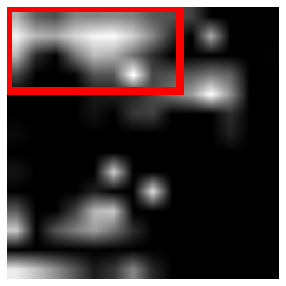

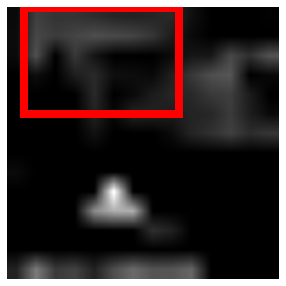

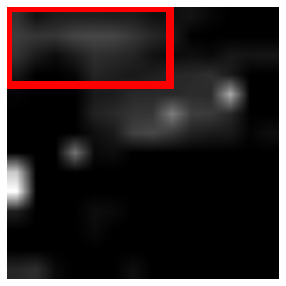

In [183]:
for bbox, index in zip(temp_bbox, test.group_bbox['conv3'][16]):
    plt.figure(figsize=(5,5))
    plt.imshow(pp_fmap['conv3'][:,:,index], cmap='gray')
    # plt.imshow(result, cmap='jet', alpha=0.5)
#     plt.colorbar()
    ax = plt.gca()
    rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], linewidth=8, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.axis('off')
    plt.show()

(-0.5, 223.5, 223.5, -0.5)

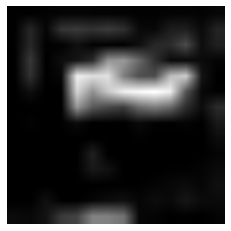

In [186]:
plt.imshow(test.postprocessed_feature_maps['conv3'][:,:,18], cmap='gray')
plt.axis('off')